<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/multiseq/multiseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Thu Jun 10 18:29:04 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 410 (delta 31), reused 79 (delta 15), pack-reused 296
Receiving objects: 100% (410/410), 391.15 MiB | 27.80 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Checking out files: 100% (116/116), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 72kB/s 
     |████████████████████████████████| 133kB 31.3MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 10.3MB 32.1MB/s 
     |████████████████████████████████| 13.2MB 32.6MB/s 
     |████████████████████████████████| 112kB 36.3MB/s 
     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 34.0MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 


In [44]:
# extract everything
!ls /content/BMGP_2020/data/multiseq/kite/*.tar.gz |xargs -n1 tar -xf
!tar -xvf /content/BMGP_2020/data/multiseq/citeseqcount_1_err/umi_count.tar.gz

umi_count/
umi_count/features.tsv.gz
umi_count/matrix.mtx.gz
umi_count/matrix.T.mtx.gz
umi_count/barcodes.tsv.gz


In [45]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [46]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [47]:
path = "/content/counts_unfiltered/adata.h5ad"
raw_kb = anndata.read_h5ad(path)

In [48]:
raw_kb

AnnData object with n_obs × n_vars = 395885 × 9
    var: 'feature_name'

In [49]:
mtx_path = "/content/umi_count/matrix.T.mtx.gz"
bcs_path = "/content/umi_count/barcodes.tsv.gz"
features_path = "/content/umi_count/features.tsv.gz"
t2g_path = "/content/BMGP_2020/references/multiseq/kite/f2b.txt"

raw_cs = import_matrix_as_anndata(mtx_path, bcs_path, features_path, t2g_path=t2g_path)
raw_cs.var.index = raw_cs.var.index.map(lambda x: x.split("-")[0])

In [50]:
filt_bcs_path = "/content/counts_filtered/cells_x_features.barcodes.txt"
filt_fea_path = "/content/counts_filtered/cells_x_features.genes.txt"

filtered_bcs = pd.read_csv(filt_bcs_path, header=None)
filtered_features = pd.read_csv(filt_fea_path, header=None)

In [51]:
common = np.intersect1d(np.intersect1d(raw_cs.obs.index.values, raw_kb.obs.index.values), nd(filtered_bcs.values))
common_features = np.intersect1d(filtered_features.values, raw_cs.var.index.values)

In [52]:
kb = raw_kb[raw_kb.obs.index.isin(common)][:,raw_kb.var.index.isin(common_features)]
cs = raw_cs[raw_cs.obs.index.isin(common)][:,raw_cs.var.index.isin(common_features)]

In [53]:
print(kb)
print(cs)

View of AnnData object with n_obs × n_vars = 6528 × 9
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 6528 × 9


In [54]:
print(False in (kb.obs.index.values == cs.obs.index.values))
print(False in (kb.var.index.values == cs.var.index.values))

True
False


In [55]:
kb = kb[kb.obs.sort_index().index]
cs = cs[cs.obs.sort_index().index]

kb = kb[:,kb.var.sort_index().index]
cs = cs[:,cs.var.sort_index().index]


In [56]:
print(True in (kb.obs.index.values != cs.obs.index.values))
print(True in (kb.var.index.values != cs.var.index.values))

False
False


# Visualizations

## Knee

In [57]:
labels = ["kb", "cs"]
colors = ["#e41a1c", "#377eb8"]

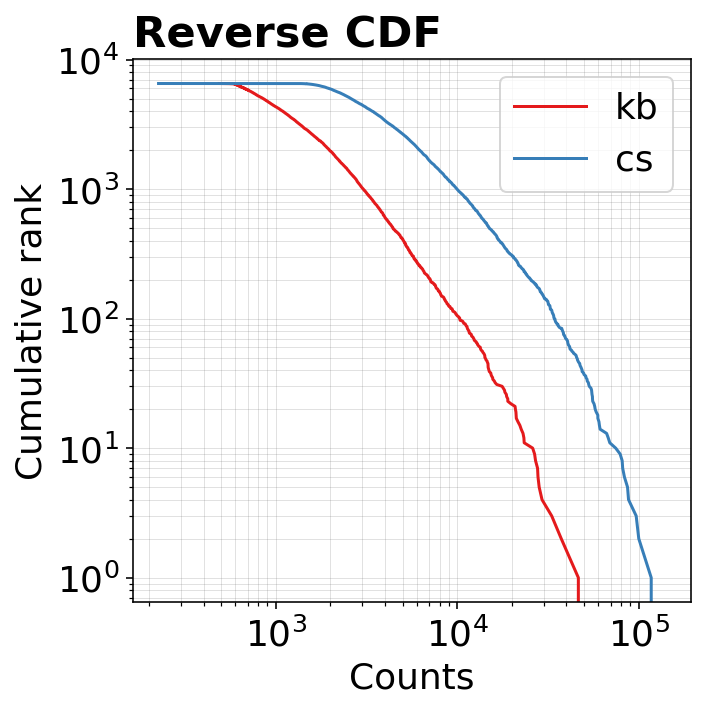

In [58]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

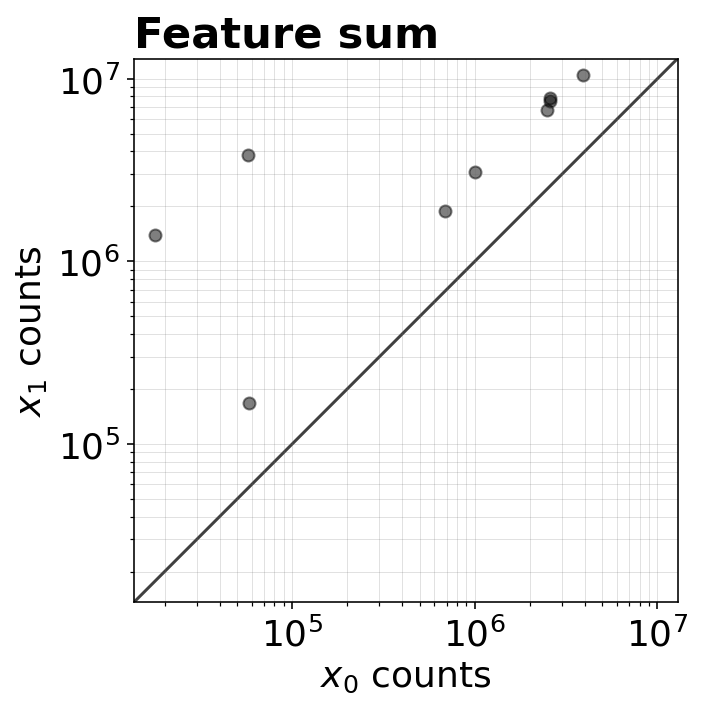

In [59]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

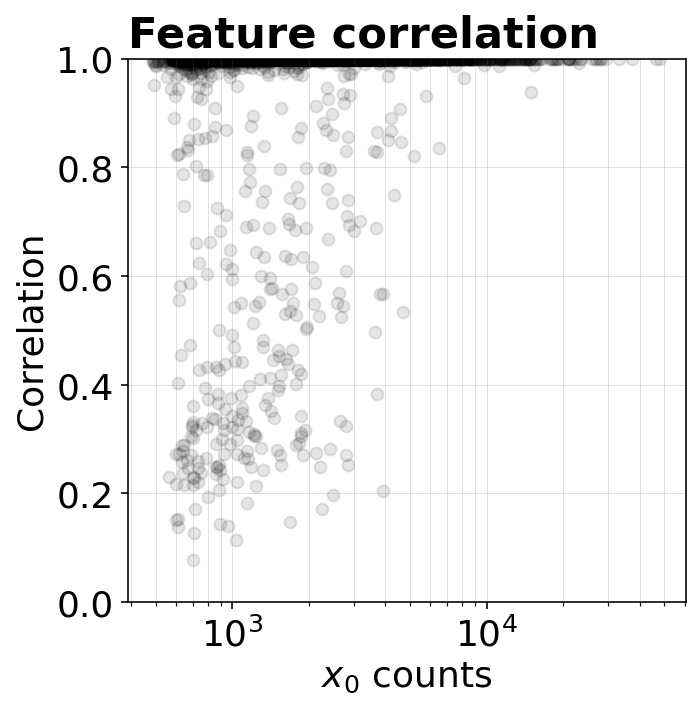

In [39]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [40]:
XX_XY = compare.l1_distance(kb.X, cs.X)
YY_YX = compare.l1_distance(cs.X, kb.X)

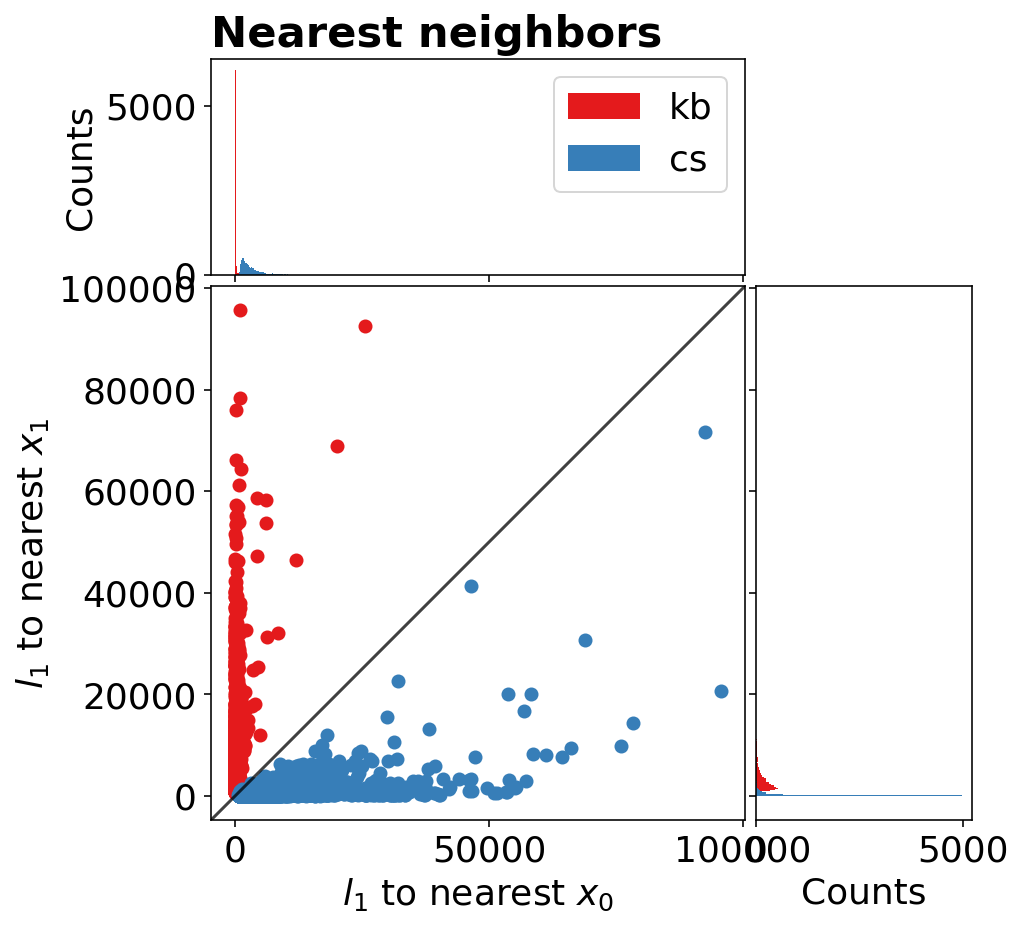

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [42]:
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

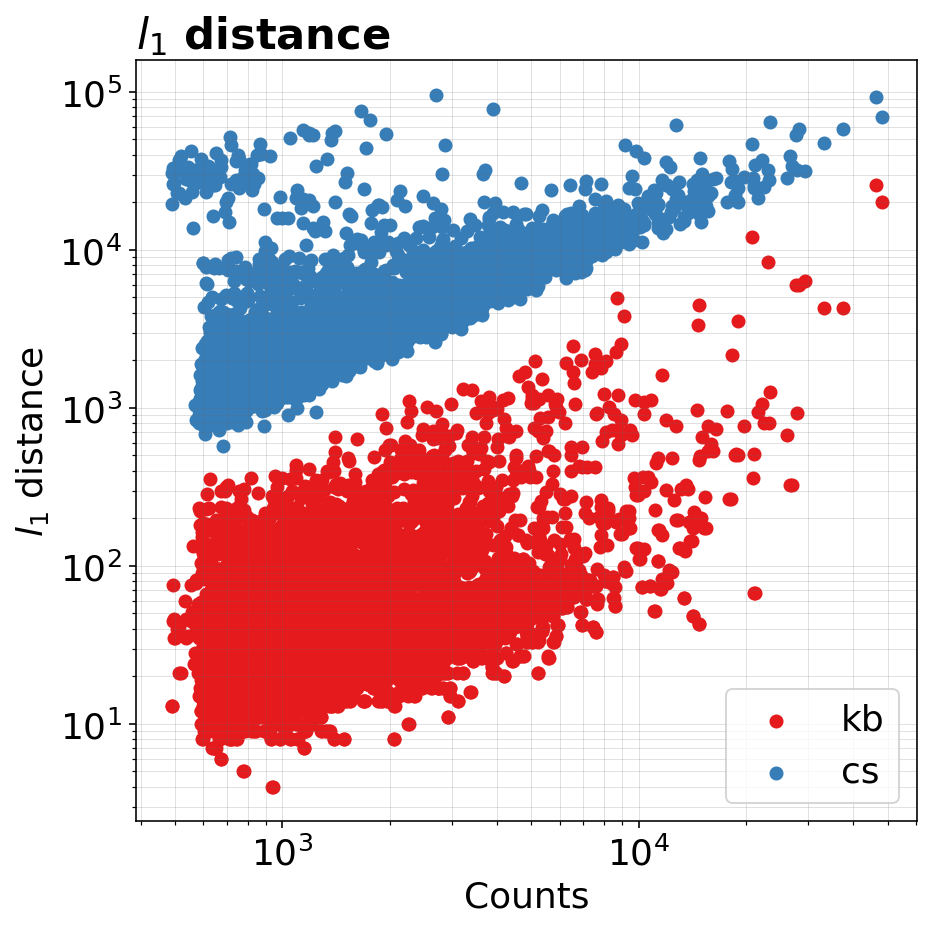

In [43]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)

fig.show()

----------------------------------------